In [1]:
random_seed= 0

# 14. Computer Vsion with CNN


### 14.2 CNN Layer


### 14.2.1 Filter(Kernel)

- creates **feature map** with filters


### 14.2.2 Stacking various feature map

- pratical CNN layer has many filters and each filter generate a single feature map
- Single CNN layer apply many filters to a input to detect various features

### 합성곱층 설명 (예제와 숫자)

| **요소**           | **설명**                                             | **예시 (숫자)**                                                                 |
| ------------------ | ---------------------------------------------------- | ------------------------------------------------------------------------------- |
| **입력 크기**      | 입력 데이터의 높이, 너비, 채널.                      | \( 32 X 32 X 3 \) (이미지 크기 32x32, RGB 채널).                                |
| **출력 크기**      | 필터 적용 후 생성된 특성 맵의 높이, 너비, 필터 개수. | \( 30 X 30 X 10 \) (필터 크기 \( 3 X 3 \), 10개의 필터 사용).                   |
| **특성 맵의 픽셀** | 특성 맵의 각 픽셀은 하나의 뉴런.                     | 특성 맵 \( 30 X 30 \) → 각 픽셀은 \( 3 X 3 X 3 \) 영역에서 값 계산.             |
| **파라미터 공유**  | 동일 필터 내의 뉴런은 같은 파라미터를 공유.          | 한 필터: \( 3 X 3 X 3 + 1 = 28 \)개의 파라미터. 10개 필터: \( 28 X 10 = 280 \). |
| **수용장의 확장**  | 한 뉴런은 입력 데이터의 특정 영역을 참조.            | \( 3 X 3 \) 높이와 너비 + 3 채널 → \( 27 \)개의 입력.                           |
| **여러 필터**      | 여러 필터가 다양한 입력 특성을 감지.                 | 가로선, 세로선, 텍스처 등 감지 가능.                                            |


### 14.2.3 CNN with Keras

- Default padding is "valid", could set "same"


In [6]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height = 70, width = 120)(images)
images = tf.keras.layers.Rescaling(scale= 1 / 255)(images)
images.shape # it's a 4D tensor

TensorShape([2, 70, 120, 3])

#### 2D CNN


In [8]:
# Create 2D CNN layer
# This layer create 32 filters with size 7 x 7 x3(same as the input channel)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [9]:
# Create 2D CNN layer with same padding
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,padding='same')
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

### 14.2.4 Memory requirement

- CNN requires a lot of memory
- suppose the input image is 150 X 100 with 3 RGB channel
- with 200 filters of 5 X 5 CNN layer, and the batch size is 100 then the required memory is 200(filter) X 150(with neurons) X 100(height neurons) X 32(32 bits) = 12 MB for each sample


# 14.3 Pooling Layer

- create a subsmaple to reduce the prameter which reduces the computation, memory usage and overfitting
- Mostly use the **Max Pooling Layer**
- it gives good amount of **invariance** which advantageous the model is not too sensitive to the little changes
- depends on the project goal, sometimes the **equvariance** is more required(sensitive the the little change)


# 14.4 Pooling Layer with Keras

- by default pooling layer used valid padding
- the modern models use **global average pooling layer** for the last layer, which gives a single average value for each feature map


In [11]:
max_poll = tf.keras.layers.MaxPool2D(pool_size=2)
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()

global_avg_pool(images) # it returns the average RGB strength for each sample 

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

# 14.5 CNN Structure

- general CNN
- INPUT -> CNN -> Pool -> CNN .... -> Pool -> FC -> Output
- it's better to use many small kernels than a few large kernels
- But the input layer commonly use more than 5X5 with stride 2
- As the model gets to the output layers, # of filter should be larger, gernerally, twice the filter after the Max pool


In [17]:
import numpy as np 


mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]



from functools import partial

tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    DefaultConv2D(filters=64, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

# 추가 코드 - 모델을 컴파일, 훈련, 평가하고 예측을 만듭니다.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
print(f"Score: {score}")
X_new = X_test[:10]  
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 86s 50ms/step - accuracy: 0.6260 - loss: 1.0465 - val_accuracy: 0.8742 - val_loss: 0.3506
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.8522 - loss: 0.4400 - val_accuracy: 0.8862 - val_loss: 0.3213
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.8799 - loss: 0.3585 - val_accuracy: 0.8994 - val_loss: 0.2864
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - accuracy: 0.8941 - loss: 0.3203 - val_accuracy: 0.8908 - val_loss: 0.3034
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 85s 50ms/step - accuracy: 0.9011 - loss: 0.2935 - val_accuracy: 0.9086 - val_loss: 0.2742
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.9115 - loss: 0.2671 - val_accuracy: 0.9074 - val_loss: 0.2612
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9139 - loss: 0.2576 - val_accuracy: 0.9066 - val_loss: 0.2666
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9214 -

### 14.5.1 LeNet-5

| Layer # | Layer Type        | Input Shape        | Output Shape | Kernel Size | Stride | Activation Function |
| ------- | ----------------- | ------------------ | ------------ | ----------- | ------ | ------------------- |
| 1       | Convolutional     | 32x32x1            | 28x28x6      | 5x5         | 1      | Tanh                |
| 2       | Subsampling (Avg) | 28x28x6            | 14x14x6      | 2x2         | 2      | Tanh                |
| 3       | Convolutional     | 14x14x6            | 10x10x16     | 5x5         | 1      | Tanh                |
| 4       | Subsampling (Avg) | 10x10x16           | 5x5x16       | 2x2         | 2      | Tanh                |
| 5       | Fully Connected   | 5x5x16 (flattened) | 120          | -           | -      | Tanh                |
| 6       | Fully Connected   | 120                | 84           | -           | -      | Tanh                |
| 7       | Fully Connected   | 84                 | 10 (Output)  | -           | -      | Softmax             |

### 설명

1. **Conv Layer 1**: 5x5 커널로 6개의 필터 적용, 입력을 28x28x6으로 변환.
2. **Subsampling Layer 1**: 2x2 필터로 평균 풀링(Avg Pooling), 출력은 14x14x6.
3. **Conv Layer 2**: 5x5 커널로 16개의 필터 적용, 출력은 10x10x16.
4. **Subsampling Layer 2**: 평균 풀링 적용 후 출력은 5x5x16.
5. **Fully Connected 1**: 5x5x16을 1D로 펼쳐 120개의 뉴런으로 연결.
6. **Fully Connected 2**: 120개의 뉴런을 84개의 뉴런으로 연결.
7. **Output Layer**: 84개의 뉴런에서 최종적으로 10개의 클래스 출력(Softmax 활성화 함수).

LeNet-5는 주로 손글씨 숫자(MNIST 데이터셋) 인식을 위해 설계됨 근데 좀 오래되서 안씀


### 14.5.2 AlexNet

| Layer # | Layer Type      | Input Shape         | Output Shape  | Kernel Size | Stride | Padding | Activation Function |
| ------- | --------------- | ------------------- | ------------- | ----------- | ------ | ------- | ------------------- |
| 1       | Convolutional   | 227x227x3           | 55x55x96      | 11x11       | 4      | VALID   | ReLU                |
| 2       | Max Pooling     | 55x55x96            | 27x27x96      | 3x3         | 2      | -       | -                   |
| 3       | Convolutional   | 27x27x96            | 27x27x256     | 5x5         | 1      | SAME    | ReLU                |
| 4       | Max Pooling     | 27x27x256           | 13x13x256     | 3x3         | 2      | -       | -                   |
| 5       | Convolutional   | 13x13x256           | 13x13x384     | 3x3         | 1      | SAME    | ReLU                |
| 6       | Convolutional   | 13x13x384           | 13x13x384     | 3x3         | 1      | SAME    | ReLU                |
| 7       | Convolutional   | 13x13x384           | 13x13x256     | 3x3         | 1      | SAME    | ReLU                |
| 8       | Max Pooling     | 13x13x256           | 6x6x256       | 3x3         | 2      | -       | -                   |
| 9       | Fully Connected | 6x6x256 (flattened) | 4096          | -           | -      | -       | ReLU                |
| 10      | Fully Connected | 4096                | 4096          | -           | -      | -       | ReLU                |
| 11      | Fully Connected | 4096                | 1000 (Output) | -           | -      | -       | Softmax             |

#### 설명

1. **Conv Layer 1**: 11x11 커널, 96개의 필터, 스트라이드 4로 Downsampling.
2. **Max Pooling 1**: 3x3 필터, 스트라이드 2, 공간 크기 감소.
3. **Conv Layer 2**: 5x5 커널, 256개의 필터, SAME 패딩 사용.
4. **Max Pooling 2**: 3x3 필터, 스트라이드 2.
5. **Conv Layer 3~5**: 3x3 커널 사용, 384/384/256 필터로 채널 수 변화.
6. **Max Pooling 3**: 3x3 필터, 스트라이드 2로 Downsampling.
7. **Fully Connected Layers**: 6x6x256을 펼쳐 4096 뉴런으로 연결, 두 개의 FC 레이어를 추가로 연결.
8. **Output Layer**: 1000개의 클래스 점수(Softmax)를 출력.

### 주요 특징

- **Dropout**: Fully Connected 레이어에서 Dropout(50%) 적용.
- **ReLU**: 활성화 함수로 ReLU(Rectified Linear Unit) 사용.
- **Local Response Normalization**: Convolutional 레이어에서 일부 결과 정규화.

AlexNet은 **ImageNet 대회(2012)**에서 우승하며 딥러닝의 부흥을 이끌었습니다. 깊고 복잡한 구조 덕분에 대규모 데이터셋에서 뛰어난 성능을 보였으며, GPU 병렬 처리를 적극 활용한 점도 큰 특징입니다.


#### Local Response Normalization (LRN)

- LRN은 입력 텐서의 채널 방향으로 국소적 정규화를 수행합니다. 즉, 입력 텐서의 특정 위치에서 주변 채널 값을 참고하여 정규화합니다.
- the most actiaved neuron suppress other neurons in different feature maps with the same position
  - one of the parameter is **depth radius** which decide the number of feature maps to apply


### 14.5.3 GoogLeNet

- GoogLeNet efficiently use the parameters with the **Inception Module**, so that it has 10 times less parameters than AlexNet

#### Incpetion Moduel

- 인셉션 모듈은 CNN 구조에서 다양한 스케일의 특징을 추출하기 위해 고안된 병렬적 설계입니다.
- 1x1 컨볼루션을 통해 계산량을 줄이고, 이후 3x3, 5x5를 합성곱을 적용하는 병렬 설계를 통해 모델의 특징 학습 능력을 강화합니다.
- GoogleLeNet의 성공에 기여한 핵심 설계로, 이후 다양한 네트워크(AlexNet, ResNet 등)에도 영향을 주었습니다.


### Regular CNN vs Depth Concatenation Layer

- 일반 합성곱은 계산량이 매우많음
- Depth Concatenation Layer은 계산을 (1) Depthwise Convolution, (2) Pointwise convolution 으로 분할하여 계산


### 14.5.4 VGGNet

- very simple structure
  - 2 ~3 CNN -> Max Pool -> 2 ~ 3 CNN -> Max Pool
- VGGNet uses many filters but use only 3 X #


### 14.5.5 ResNet

- Uses Residual Network
- It has very deep(152 layers) network by using **skip(short cut) connection**


#### Residual Learning

- 잔차 학습은 출력값을 직접 학습하지 않고, **출력값과 입력값의 차이**를 학습하는 방식
- 모델이 H(x)라는 복잡한 함수를 훈련할때, H(x)를 두가지로 나눔
  - H(x) = F(x) + x, where f(x) = H(x) - x and x is input
  - F(x): 잔차함수
  - x : 입력
- 잔차 학습은 모델이 복잡한 계산을 하지 않도록 유도
  - 네트워크가 입력 x를 거의 그대로 출력해야 한다면, 𝐹 ( 𝑥 ) F(x)는 0에 가까운 간단한 값을 학습하면 됩니다. -> 훈련 속도 가속화
  - 스킵 연결은 입력 x를 출력으로 강제로 전달하기 때문에, 모델은 최소한 x를 보존하면서 필요한 변화만 학습 -> 기울기 소실 문제 해결


### 14.5.6 Xception

- Xception은 Inception 모듈을 확장하여 개발된 CNN 모델
- Depthwise Separable Convolution을 사용해 효율성을 높이고 계산량을 줄이면서도 성능을 유지

1. Inception의 확장:

   - Inception 모듈을 더 극단적으로 단순화.
   - Depthwise Separable Convolution으로 인셉션 구조를 대체.

2. Depthwise Separable Convolution:
   - 일반적인 𝐾 × 𝐾 합성곱을:
     - Depthwise Convolution (공간적 특징 학습).
     - Pointwise Convolution (1x1 Conv) (채널 간 결합).
   - 계산량을 줄이고 특징 표현력을 극대화.
3. 네트워크의 가정:
   - 공간적 연산과 채널 간 연산이 독립적으로 학습될 수 있다는 가정을 기반으로 설계.


### 14.5.7 SENet

- 채널 간의 중요도를 학습하여 성능을 향상시키는 CNN 모델
- **“Squeeze-and-Excitation”**라는 독특한 메커니즘을 통해 채널 간의 상호작용을 모델링하여, 각 채널의 중요도를 동적으로 조정

- SENet은 다음의 문제를 해결하려고 합니다:

  - 기존 CNN은 각 채널을 독립적으로 취급하며, 서로 다른 채널 간의 상호작용이나 중요도 차이를 제대로 반영하지 못합니다.

- SENet의 해결 방법:
  - Squeeze-and-Excitation 모듈을 추가하여, 네트워크가 각 채널의 중요도를 학습하도록 설계.
  - 특정 채널의 가중치를 조정(증폭 또는 억제)함으로써, 중요한 특징이 더 부각되도록 만듭니다.

#### SENet의 장점

1. 채널 간 상호작용 학습:

- 각 채널의 중요도를 학습하여, 특징 간의 관계를 잘 반영합니다.

2. 모델 성능 향상:

- ImageNet, CIFAR-10, COCO 등 다양한 데이터셋에서 기존 네트워크 대비 높은 성능을 보여줍니다.

3. 간단한 통합:

- SE 모듈은 기존 네트워크에 간단히 추가 가능하며, 계산량 증가가 비교적 적습니다.

4. 확장성:

- 다양한 CNN 구조(ResNet, Inception, MobileNet 등)에 적용 가능.


### 14.5.8 Efficient Net

- EfficientNet은 효율적인 모델 스케일링 전략을 도입해 성능과 계산 효율성을 극대화
- 가장 중요한 모델

#### 핵심 아이디어

- EfficientNet은 기존의 CNN 모델에서 사용되던 비효율적인 스케일링 방식을 개선하여, 적은 계산량으로 더 높은 성능을 달성합니다.

1. 스케일링 문제
   - 일반적으로 모델 성능을 높이기 위해 네트워크를 확장(Scaling)할 때:
     - 넓이 증가(Width Scaling): 필터 개수를 늘림.
     - 깊이 증가(Depth Scaling): 레이어 수를 늘림.
     - 해상도 증가(Resolution Scaling): 입력 이미지 크기를 키움.
   - 이러한 방법을 독립적으로 사용하면 계산량이 급격히 증가하거나, 자원이 비효율적으로 사용될 수 있음.
2. Compound Scaling
   - EfficientNet은 Compound Scaling을 제안하여 깊이, 넓이, 해상도를 동시에 적절히 확장합니다:

#### EfficientNet의 장점

1. 효율성:
   - 적은 계산량(FLOPs)으로도 높은 성능을 달성.
2. 범용성:
   - 분류(Classification), 검출(Detection), 세그멘테이션(Segmentation) 등 다양한 비전 작업에 적용 가능.
3. 확장성:
   - Compound Scaling으로 네트워크를 효율적으로 확장.
4. 최적 설계:
   - NAS를 통해 기본 모델(B0)을 최적화하여 설계.


### 14.5.9 Choosing right CNN

https://keras.io/api/applications

- above website has all information about prebuild model in **tf.keras.application** package


### 14.7 Using Pre-trained models


In [66]:
model = tf.keras.applications.ResNet50V2(weights="imagenet")

images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)
images_resized = tf.cast(images_resized, dtype=tf.float32)

inputs = tf.keras.applications.resnet_v2.preprocess_input(images_resized)

Y_proba = model.predict(inputs)
Y_proba.shape

top_K = tf.keras.applications.resnet_v2.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"이미지 #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
이미지 #0
  n03877845 - palace       89.98%
  n02825657 - bell_cote    7.27%
  n03781244 - monastery    1.45%
이미지 #1
  n03445777 - golf_ball    85.54%
  n03530642 - honeycomb    6.67%
  n07760859 - custard_apple 6.59%


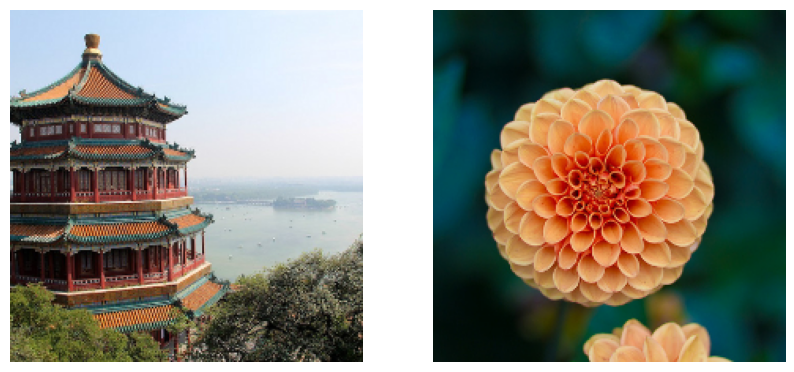

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

### 14.8 Transfer Learning

- sometimes, if we do not have enough data, we can perform the transfer learning
